# C言語によるはじめて学ぶ信号処理

をJuliaで実装したやつ

[C言語による はじめて学ぶ信号処理｜コロナ社](http://www.coronasha.co.jp/np/isbn/9784339008470/)

## 準備

In [1]:
versioninfo()

Julia Version 1.1.0
Commit 80516ca202 (2019-01-21 21:24 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
  CPU: Intel(R) Core(TM) i7-7700K CPU @ 4.20GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-6.0.1 (ORCJIT, skylake)


In [2]:
using Base, Plots, WAV, BenchmarkTools

In [3]:
gr()

Plots.GRBackend()

## リングバッファ

本にはないけど便利そうなので書いてみた。

In [4]:
mutable struct CircularBuffer{T<:Real}
    data::Array{T}
    size::Int64
    first::Int64
    last::Int64
    CircularBuffer{T}(N::Int64) where {T<:Real} = new(zeros(T, N), N, 1, 1)
end

[]演算子のオーバーロードに相当

In [5]:
function Base.getindex(buf::CircularBuffer, i::Int64)
    return buf.data[mod(i + buf.first - 1, buf.size) + 1]
end

データ操作

In [6]:
function pushfront(buf, x)
    buf.data[buf.first] = x
    buf.first = mod(buf.first - 2, buf.size) + 1
end

pushfront (generic function with 1 method)

In [7]:
function pushback(buf, x)
    buf.data[buf.last] = x
    buf.last = mod(buf.last, buf.size) + 1
end

pushback (generic function with 1 method)

for debug

In [8]:
function showCircle(buf)
    N = length(buf.data)
    for i = 1:N
        arrow = ""
        if i == buf.first
            arrow = string(arrow, " <- first")
        end
        if i == buf.last
            arrow = string(arrow, " <- last")
        end
        println(buf.data[i], arrow)
    end
end

showCircle (generic function with 1 method)

## インパルス応答

In [9]:
function impulse(N::Int64)
    if N < 1
        return 0
    end
    imp = zeros(Float64, N)
    imp[1] = 1
    return imp
end

impulse (generic function with 1 method)

In [10]:
function IIR(x, a, b, tap)
    N = length(x)
    y = zeros(Float64, N)
    mem = CircularBuffer{Float64}(tap)
    for i = 1:N
        v    = x[i]   + sum([mem[i]*b[i]   for i in 1:tap])
        y[i] = v*a[1] + sum([mem[i]*a[i+1] for i in 1:tap])
        pushfront(mem, v)
    end
    return y
end

IIR (generic function with 1 method)

In [11]:
function irtest1()
    imp = impulse(128)
    a = [0.049283  0.098566 0.049283]
    b = [1.2813   -0.47844]
    return IIR(imp, a, b, 2)
end

irtest1 (generic function with 1 method)

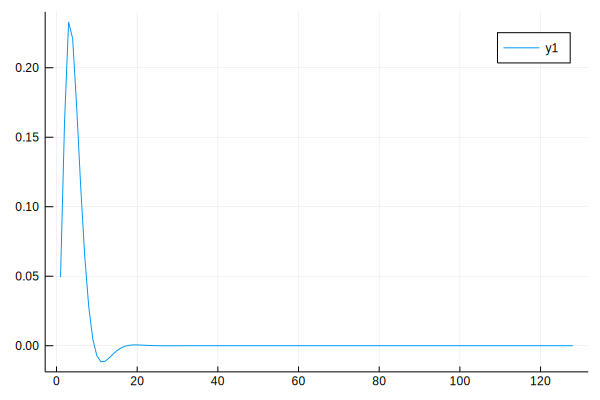

In [12]:
Plots.plot(irtest1())

In [13]:
function irtest2()
    imp = impulse(128)
    a = [0.1 0 0]
    b = [0.9 0]
    return IIR(imp, a, b, 1)
end

irtest2 (generic function with 1 method)

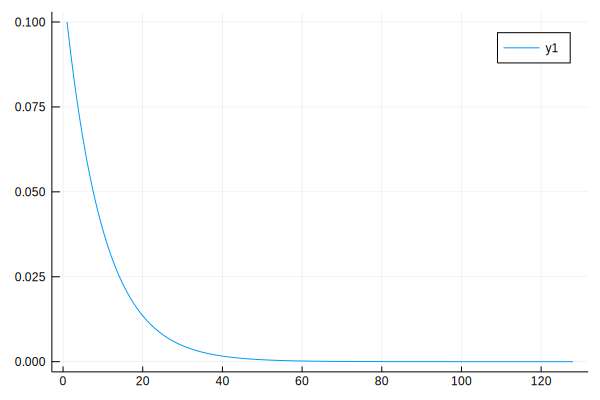

In [14]:
Plots.plot(irtest2())

In [15]:
function FIR(x, a, tap)
    N = length(x)
    y = zeros(Float64, N)
    mem = CircularBuffer{Float64}(tap)
    for i = 1:N
        v    = x[i]
        y[i] = v*a[1] + sum([mem[i]*a[i+1] for i in 1:tap])
        pushfront(mem, v)
    end
    return y
end

FIR (generic function with 1 method)

In [16]:
function irtest3()
    imp = impulse(128)
    a = [0.5 0.5 0.5]
    return FIR(imp, a, 2)
end

irtest3 (generic function with 1 method)

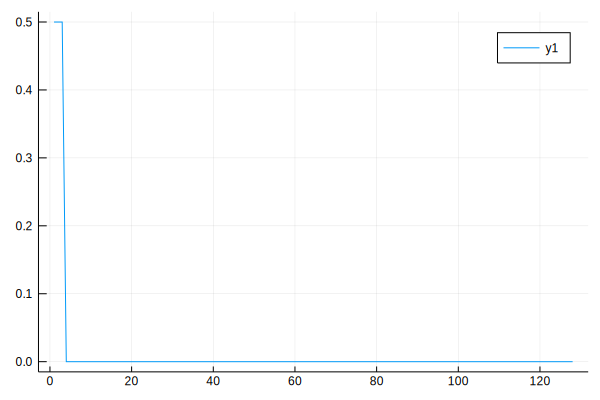

In [17]:
Plots.plot(irtest3())

## ステップ応答

In [18]:
function step(N::Int64)
    return ones(Float64, N)
end

step (generic function with 1 method)

In [19]:
function steptest1()
    st = step(128)
    a = [0.1 0 0]
    b = [0.9 0]
    return IIR(st, a, b, 1)
end

steptest1 (generic function with 1 method)

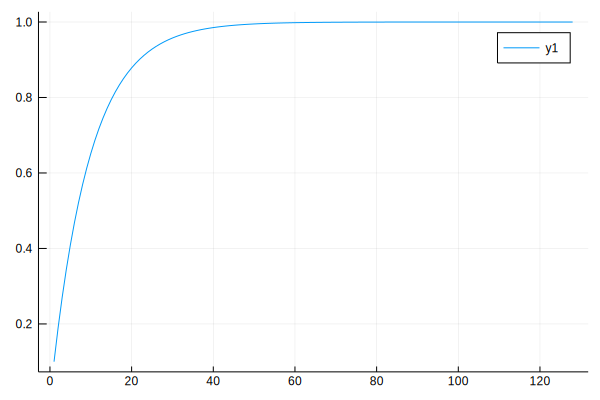

In [20]:
Plots.plot(steptest1())

In [21]:
function steptest2()
    st = step(128)
    a = [0.049283  0.098566 0.049283]
    b = [1.2813   -0.47844]
    return IIR(st, a, b, 2)
end

steptest2 (generic function with 1 method)

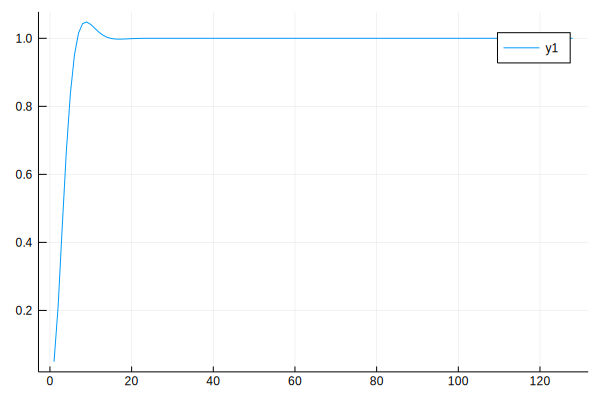

In [22]:
Plots.plot(steptest2())

In [23]:
function steptest3()
    st = step(128)
    a = [0.5 0.5 0.5]
    return FIR(st, a, 2)
end

steptest3 (generic function with 1 method)

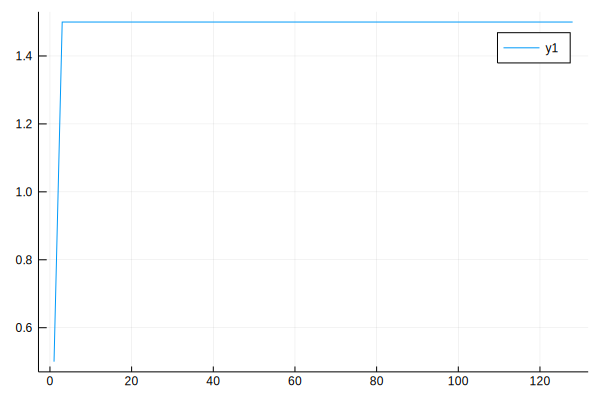

In [24]:
Plots.plot(steptest3())

## 振幅・位相特性

In [25]:
function toGain(x)
    return 20*log10(abs(x))
end

toGain (generic function with 1 method)

In [26]:
function ampChar(ω, a, b, Ts)
    return a/sqrt(1+b^2-2b*cos(ω*Ts))
end

ampChar (generic function with 1 method)

In [27]:
ampChar1(ω) = toGain(ampChar(ω, 0.1, 0.9, 10))

ampChar1 (generic function with 1 method)

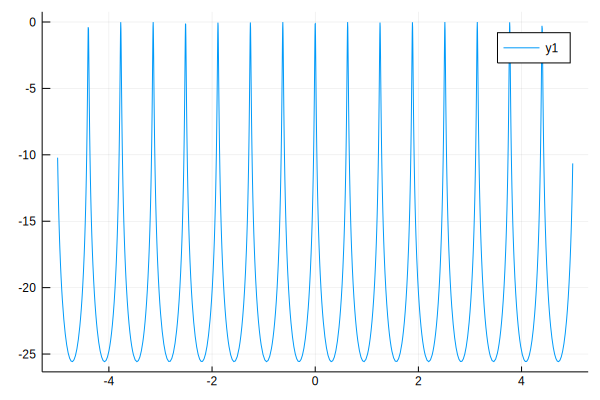

In [28]:
Plots.plot(ampChar1)

In [29]:
function phaChar(ω, a, b, Ts)
    return -atan(b*sin(ω*Ts)/(1-b+cos(ω*Ts)))
end

phaChar (generic function with 1 method)

In [30]:
phaChar1(ω) = phaChar(ω, 0.1, 0.9, 10)

phaChar1 (generic function with 1 method)

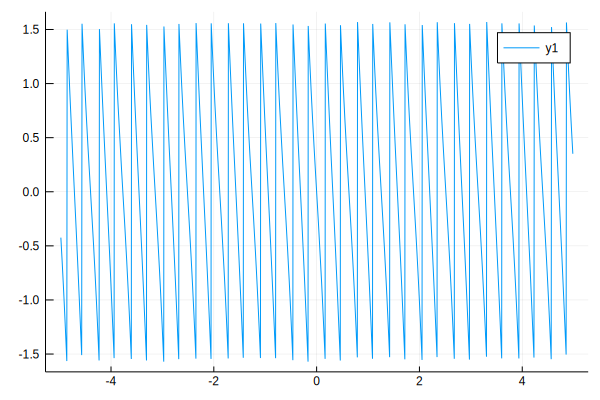

In [31]:
Plots.plot(phaChar1)

## フーリエ変換

In [32]:
function DFT(x, N)
    W = reshape([exp(-im*2*pi*i*j/N) for i = 0:N-1 for j = 0:N-1], (N, N))
    return W*x[1:N]
end

DFT (generic function with 1 method)

In [33]:
function DFTTest()
    N  = 1024
    wav, fs = wavread("guitar.wav")
    x = wav[1:N, 1]
    Plots.plot(abs.(DFT(x, N)), scale=:log10)
end

DFTTest (generic function with 1 method)

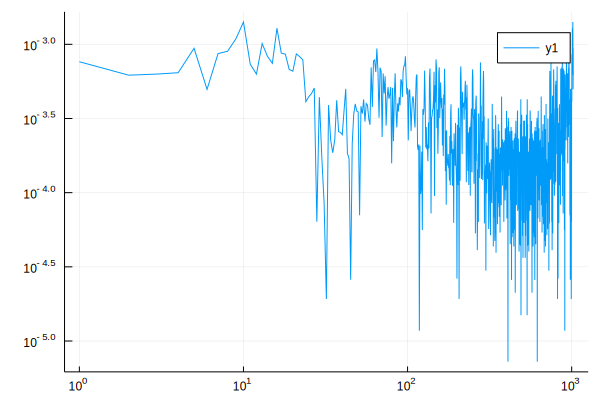

In [34]:
DFTTest()

In [35]:
function butterfly(x, y, N, W, step)
    if (N < 2) return end
    div = Int64(N/2)
    for i = 1:div
        y[i]     = x[i] + x[i+div]
        y[i+div] = W[(i-1)*step+1] * (x[i] - x[i+div])
        x[i]     = y[i]
        x[i+div] = y[i+div]
    end
    butterfly(view(x, 1:div), view(y, 1:div), div, W, step*2)
    butterfly(view(x, div+1:N), view(y, div+1:N), div, W, step*2)
end

butterfly (generic function with 1 method)

In [36]:
function bitrev(x, N, step)
  br = 0
  for n=1:step
    tmp = br*2
    br = [tmp; tmp.+1]
  end
  br = br.+1
    
  for i = 1:N
    if br[i] > i
      tmp = x[br[i]]
      x[br[i]] = x[i]
      x[i] = tmp
    end
  end

  return x
end

bitrev (generic function with 1 method)

In [37]:
function FFT(x, N)
    step = log(2, N)
    if !isinteger(step)
        println("not 2^n")
        return
    end
    
    x = complex(x[1:N])
    y = copy(x)
    W = [exp(-im*2*pi*k/N) for k = 0:N/2-1]

    butterfly(x, y, N, W, 1)
    
    return bitrev(y, N, step)
end

FFT (generic function with 1 method)

In [38]:
function FFTTest()
    N = 1024
    wav, fs = wavread("guitar.wav")
    x = wav[1:N, 1]
    Plots.plot(abs.(FFT(x, N)), scale=:log10)
end

FFTTest (generic function with 1 method)

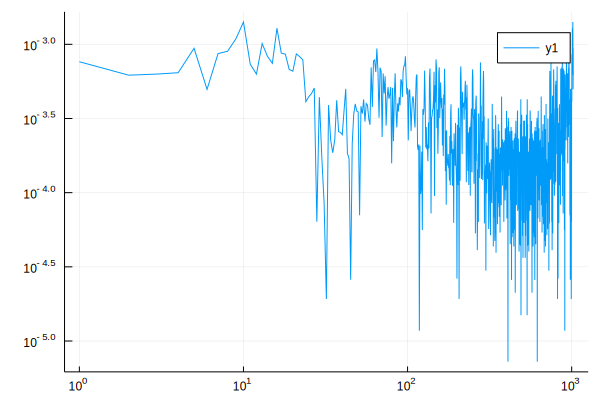

In [39]:
FFTTest()

In [40]:
N = 1024
s = rand(Float64, N)
@btime DFT($s, $N);
@btime FFT($s, $N);

  34.603 ms (26 allocations: 17.04 MiB)
  71.316 μs (4125 allocations: 283.19 KiB)


## 窓関数

In [41]:
function hanning(N)
    return [0.5*(1-cos(2pi*k/N)) for k = 0:N-1]
end

hanning (generic function with 1 method)

In [42]:
function hamming(N)
    return [0.54-0.46cos(2pi*k/N) for k = 0:N-1]
end

hamming (generic function with 1 method)

In [43]:
function blackman(N)
    return [0.42-cos(2pi*k/N)/2+0.08*cos(4pi*k/N) for k = 0:N-1]
end

blackman (generic function with 1 method)

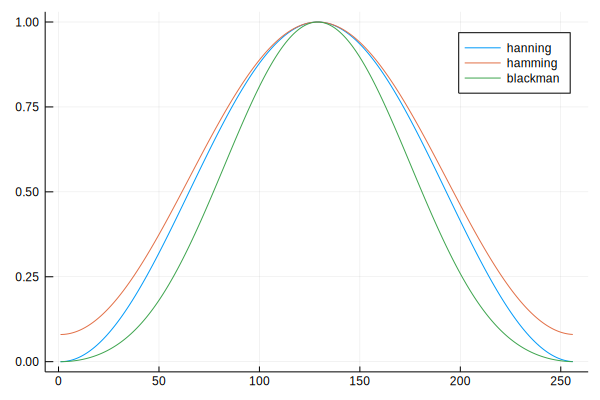

In [44]:
Plots.plot(hanning(256), label="hanning")
Plots.plot!(hamming(256), label="hamming")
Plots.plot!(blackman(256), label="blackman")

In [45]:
function WindowedFFTTest()
    N = 1024
    wav, fs = wavread("guitar.wav")
    x = wav[1:N, 1]
    
    Plots.plot()
    
    Plots.plot!(abs.(FFT(x, N)), scale=:log10, label="no window")
    
    han = x.*hanning(N)
    Plots.plot!(abs.(FFT(han, N)), scale=:log10, label="hanning")
    
    ham = x.*hamming(N)
    Plots.plot!(abs.(FFT(ham, N)), scale=:log10, label="hamming")
    
    
    bla = x.*blackman(N)
    Plots.plot!(abs.(FFT(bla, N)), scale=:log10, label="blackman")
end

WindowedFFTTest (generic function with 1 method)

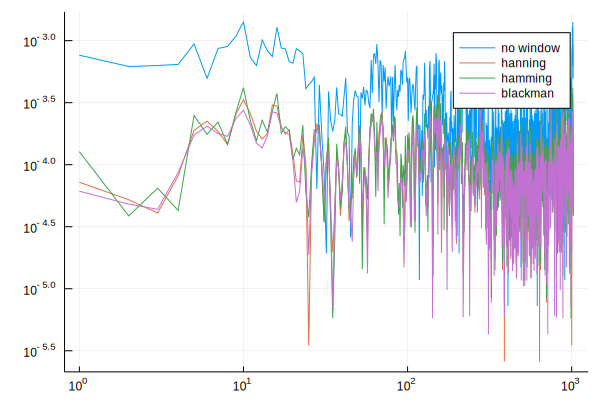

In [46]:
WindowedFFTTest()